In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
data_dir = '/content/drive/My Drive/Final Project/chest_xray/chest_xray'

TRAIN = 'train'
TEST = 'test'
VAL = 'val'

In [36]:
# define augmentation

def apply_transform(mode=None):

    if mode == 'train':
        transform = T.Compose([T.Resize((256,256)),
                               T.RandomHorizontalFlip(),
                               T.RandomRotation((-20,+20)),
                               T.CenterCrop(224),
                               T.ToTensor(),
                               T.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
                              ])

    elif mode == 'test' or mode == 'val':
        transform = T.Compose([T.Resize((256,256)),
                               T.CenterCrop(224),
                               T.ToTensor(),
                               T.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
                              ])
        
    return transform

In [37]:
# Initialize dataset

trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN),
                                transform = apply_transform(TRAIN))

valset = datasets.ImageFolder(os.path.join(data_dir,VAL),
                              transform = apply_transform(VAL))

testset = datasets.ImageFolder(os.path.join(data_dir, TEST),
                               transform = apply_transform(TEST))

In [38]:
print('Name of Labels:', trainset.classes)
print('Index of Labels:', trainset.class_to_idx)

Name of Labels: ['NORMAL', 'PNEUMONIA']
Index of Labels: {'NORMAL': 0, 'PNEUMONIA': 1}


In [39]:
# define methods for class-count visualization

def class_count(dataset):
    count = dict(Counter(dataset.targets))
    count = dict(zip(dataset.classes[::-1], list(count.values())))      # changing keys of dictionary 
    return count

def plot_class_count(dataset, name='Dataset Labels Count'):
    count = class_count(dataset)
    pd.DataFrame(count, index=['Labels']).plot(kind='bar', title=name).show()

AttributeError: ignored

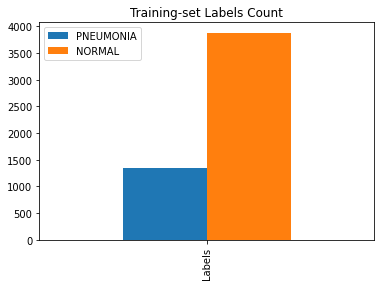

In [99]:
plot_class_count(trainset, name='Training-set Labels Count')

AttributeError: ignored

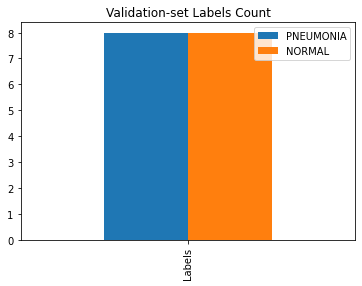

In [73]:
plot_class_count(valset, name='Validation-set Labels Count')

AttributeError: ignored

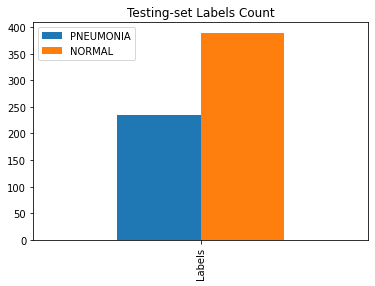

In [74]:
plot_class_count(testset, name='Testing-set Labels Count')

In [40]:
# define dataloaders

train_loader = DataLoader(trainset,
                          batch_size=16,
                          shuffle=True)

val_loader = DataLoader(valset,
                        batch_size=8)

test_loader = DataLoader(testset,
                         batch_size=8)

In [41]:
# Display information about dataloaders

print('Training Images:')
dataiter = iter(train_loader)
images,labels = dataiter.next()
print("shape of images : {}".format(images.shape))
print("shape of labels : {}".format(labels.shape))

print('\nValidation Images:')
dataiter = iter(val_loader)
images,labels = dataiter.next()
print("shape of images : {}".format(images.shape))
print("shape of labels : {}".format(labels.shape))

print('\nTest Images:')
dataiter = iter(test_loader)
images,labels = dataiter.next()
print("shape of images : {}".format(images.shape))
print("shape of labels : {}".format(labels.shape))

Training Images:
shape of images : torch.Size([16, 3, 224, 224])
shape of labels : torch.Size([16])

Validation Images:
shape of images : torch.Size([8, 3, 224, 224])
shape of labels : torch.Size([8])

Test Images:
shape of images : torch.Size([8, 3, 224, 224])
shape of labels : torch.Size([8])


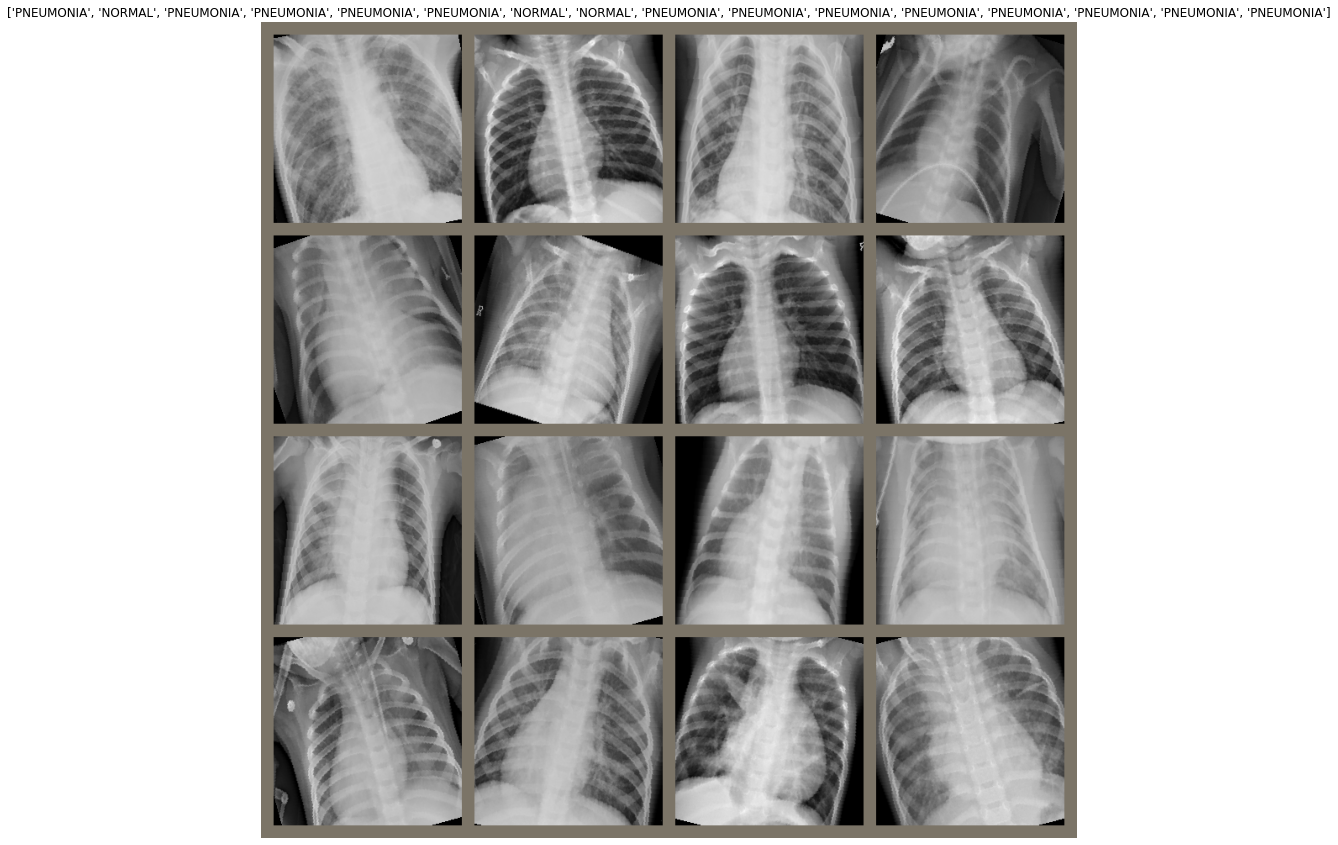

In [42]:
def denoramlize(img):
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    img = img*std + mean
    img = np.clip(img,0,1)
    return img

def imshow(img, title=None):
    img = denoramlize(img)
    plt.figure(figsize=[15, 15])
    plt.axis('off')
    plt.imshow(img)
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    images = make_grid(images, nrow=4, padding=15)
    imshow(images, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])

show_batch_images(train_loader)

In [43]:
# define method to create model and set running device('cuda' or 'cpu')

def get_model(num_class=2, pretrained=True):

    model = torchvision.models.vgg19(pretrained=pretrained)

    # freeze the model layer
    for param in model.parameters():
        param.requires_grad = False

    # add Linear classifier layer
    in_features = model.classifier[0].in_features
    classifier = nn.Sequential(
        nn.Linear(in_features, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 2),
        nn.LogSoftmax(dim=1)
    )
    model.classifier = classifier
    return model

model = get_model(num_class=2, pretrained=True)
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Adam Optimizer

In [45]:
criterion = nn.CrossEntropyLoss()                   

optimizer_Adam = optim.Adam(model.parameters(), lr=0.001)

schedular_Adam = optim.lr_scheduler.ReduceLROnPlateau(optimizer_Adam, factor=0.1, patience=3)

def accuracy(preds, labels):
    preds = torch.exp(preds)
    top_p,top_class = preds.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [46]:
epochs = 15
val_loss_min = np.Inf

for epoch in range(epochs):

    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    
    model.train()
    for images,labels in iter(train_loader):
        optimizer_Adam.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_Adam.step()

        train_loss += loss.item()
        train_acc += accuracy(preds, labels)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    model.eval()
    with torch.no_grad():
        for images,labels in iter(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            val_acc += accuracy(preds, labels)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)

    schedular_Adam.step(avg_val_loss)

    print("Epoch : {} \ntrain_loss : {:.6f}, \tTrain_acc : {:.6f}, \nVal_loss : {:.6f}, \tVal_acc : {:.6f}".format(epoch + 1,
                                                                                                                   avg_train_loss, avg_train_acc,
                                                                                                                   avg_val_loss, avg_val_acc))


Epoch : 1 
train_loss : 0.410527, 	Train_acc : 0.905772, 
Val_loss : 0.369215, 	Val_acc : 0.812500
Epoch : 2 
train_loss : 0.326705, 	Train_acc : 0.922346, 
Val_loss : 0.178985, 	Val_acc : 0.875000
Epoch : 3 
train_loss : 0.290871, 	Train_acc : 0.932476, 
Val_loss : 0.278399, 	Val_acc : 0.875000
Epoch : 4 
train_loss : 0.252685, 	Train_acc : 0.938456, 
Val_loss : 1.896549, 	Val_acc : 0.750000
Epoch : 5 
train_loss : 0.287246, 	Train_acc : 0.937500, 
Val_loss : 0.156644, 	Val_acc : 0.937500
Epoch : 6 
train_loss : 0.293549, 	Train_acc : 0.934387, 
Val_loss : 7.009894, 	Val_acc : 0.500000
Epoch : 7 
train_loss : 0.278269, 	Train_acc : 0.941131, 
Val_loss : 0.379048, 	Val_acc : 0.687500
Epoch : 8 
train_loss : 0.215622, 	Train_acc : 0.947057, 
Val_loss : 0.538662, 	Val_acc : 0.875000
Epoch : 9 
train_loss : 0.235049, 	Train_acc : 0.943562, 
Val_loss : 0.436786, 	Val_acc : 0.875000
Epoch : 10 
train_loss : 0.143473, 	Train_acc : 0.951780, 
Val_loss : 0.523544, 	Val_acc : 0.687500
Epoch : 1

In [47]:
# Evaluate the model performance

model.eval()

test_loss = 0
test_acc = 0
for images,labels in iter(test_loader):

    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)
    loss = criterion(preds,labels)
    test_loss += loss.item()
    test_acc += accuracy(preds,labels)

avg_test_loss = test_loss/len(test_loader)
avg_test_acc = test_acc/len(test_loader)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(avg_test_loss,avg_test_acc))

Test Loss : 0.996304 Test Acc : 0.762821


## SGD Optimizer

In [48]:
criterion = nn.CrossEntropyLoss()                   

optimizer_SGD = optim.SGD(model.parameters(), lr=0.001)

schedular_SGD= optim.lr_scheduler.ReduceLROnPlateau(optimizer_Adam, factor=0.1, patience=3)

def accuracy(preds, labels):
    preds = torch.exp(preds)
    top_p,top_class = preds.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [49]:
epochs = 15
val_loss_min = np.Inf

for epoch in range(epochs):

    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    
    model.train()
    for images,labels in iter(train_loader):
        optimizer_SGD.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_SGD.step()

        train_loss += loss.item()
        train_acc += accuracy(preds, labels)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    model.eval()
    with torch.no_grad():
        for images,labels in iter(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            val_acc += accuracy(preds, labels)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)

    schedular_SGD.step(avg_val_loss)

    print("Epoch : {} \ntrain_loss : {:.6f}, \tTrain_acc : {:.6f}, \nVal_loss : {:.6f}, \tVal_acc : {:.6f}".format(epoch + 1,
                                                                                                                   avg_train_loss, avg_train_acc,
                                                                                                                   avg_val_loss, avg_val_acc))

Epoch : 1 
train_loss : 0.083334, 	Train_acc : 0.963112, 
Val_loss : 0.383304, 	Val_acc : 0.750000
Epoch : 2 
train_loss : 0.087958, 	Train_acc : 0.965787, 
Val_loss : 0.383705, 	Val_acc : 0.750000
Epoch : 3 
train_loss : 0.095835, 	Train_acc : 0.966361, 
Val_loss : 0.385954, 	Val_acc : 0.750000
Epoch : 4 
train_loss : 0.093778, 	Train_acc : 0.965787, 
Val_loss : 0.401171, 	Val_acc : 0.750000
Epoch : 5 
train_loss : 0.103971, 	Train_acc : 0.962729, 
Val_loss : 0.398364, 	Val_acc : 0.750000
Epoch : 6 
train_loss : 0.090042, 	Train_acc : 0.966252, 
Val_loss : 0.387043, 	Val_acc : 0.750000
Epoch : 7 
train_loss : 0.094412, 	Train_acc : 0.963303, 
Val_loss : 0.374768, 	Val_acc : 0.750000
Epoch : 8 
train_loss : 0.090744, 	Train_acc : 0.966170, 
Val_loss : 0.392786, 	Val_acc : 0.750000
Epoch : 9 
train_loss : 0.085644, 	Train_acc : 0.965214, 
Val_loss : 0.385597, 	Val_acc : 0.750000
Epoch : 10 
train_loss : 0.094277, 	Train_acc : 0.965105, 
Val_loss : 0.386808, 	Val_acc : 0.750000
Epoch : 1

In [50]:
# Evaluate the model performance

model.eval()

test_loss = 0
test_acc = 0
for images,labels in iter(test_loader):

    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)
    loss = criterion(preds,labels)
    test_loss += loss.item()
    test_acc += accuracy(preds,labels)

avg_test_loss = test_loss/len(test_loader)
avg_test_acc = test_acc/len(test_loader)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(avg_test_loss,avg_test_acc))

Test Loss : 0.974451 Test Acc : 0.764423
